<img src="../Pierian-Data-Logo.PNG">
<br>
<strong><center>Copyright 2019. Created by Jose Marcial Portilla.</center></strong>

# RNN Exercises
For these exercises we're using data from the Federal Reserve Economic Database (FRED) concerning Electricity and Gas Utilities Production from January 1992 to January 2019 (325 records).

Data source: https://fred.stlouisfed.org/series/IPG2211A2N

In the exercises below you'll be asked to do the following:
* Perform standard imports, load & plot the dataset (code provided)
* Prepare data for an LSTM model
* Define the LSTM model, loss and optimization functions
* Train the model
* Evaluate the model on test data
* OPTIONAL: Plot the results

<div class="alert alert-danger" style="margin: 10px"><strong>IMPORTANT NOTE!</strong> Make sure you don't run the cells directly above the example output shown, <br>otherwise you will end up writing over the example output!</div>

## Perform standard imports, load and plot the dataset
Run the cells below to load the libraries needed for this exercise and the Energy Production dataset, and to plot the data.

In [1]:
# RUN THIS CELL
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

df = pd.read_csv('../Data/TimeSeriesData/Energy_Production.csv',index_col=0,parse_dates=True)
df.dropna(inplace=True)
print(len(df))
df.head()

325


,IPG2211A2N
DATE,
1992-01-01,85.5560
1992-02-01,80.4178
1992-03-01,74.7390
1992-04-01,69.8367
1992-05-01,67.3781


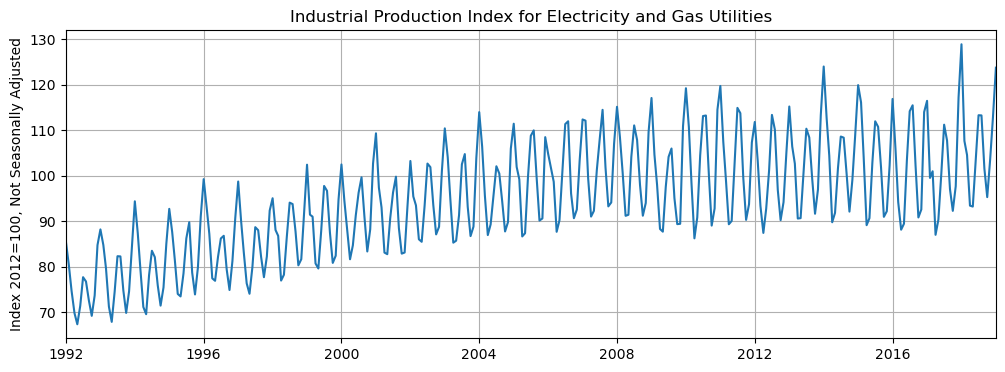

In [2]:
# RUN THIS CELL
plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.show()

# Prepare the data
For the first set of exercises we'll
* divide the data into train and test sets
* normalize the training set
* prepare windowed seq/label tuples for an LSTM model

## 1. Divide the data into train and test sets
Working with a window_size of 12, divide the dataset into a sequence of 313 training records (including the window), and a test set of 12 records.

In [3]:
# CODE HERE
y = df['IPG2211A2N'].values.astype(float)

test_size = 12 
train_size = len(y) - test_size
window_size = 12

train_set = y[:train_size]
test_set = y[train_size:]

In [4]:
# Run the code below to check your results:
print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 313
Test:  12


In [3]:
# DON'T WRITE HERE

Train: 313
Test:  12


## 2. Normalize the training set
Feature scale the training set to fit within the range [-1,1].

In [5]:
# CODE HERE
scaler = MinMaxScaler(feature_range=(-1, 1))


train_norm = scaler.fit_transform(train_set.reshape(-1,1))

In [6]:
# Run the code below to check your results:
print(f'First item, original: {train_set[0]}')
print(f'First item, scaled:  {train_norm[0]}')

First item, original: 85.556
First item, scaled:  [-0.4091274]


In [4]:
# DON'T WRITE HERE

First item, original: 85.556
First item, scaled: [-0.4091274]


## 3. Prepare data for LSTM
Prepare the list of windowed sequence/label tuples to be fed into an LSTM model.

In [7]:
# RUN THIS CELL
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq,ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [8]:
# CODE HERE

train_data = input_data(train_norm,window_size)

In [9]:
# Run the code below to check your results:
print(f'Train_data: {len(train_data)}')  # should equal 301

Train_data: 301


In [6]:
# DON'T WRITE HERE

Train_data: 301


## 4. Define the model
Design a model that has a (1,64) LSTM layer and a (64,1) fully-connected linear layer. Be sure to initialize $h_0$ and $c_0$, and return only the last predicted value.

In [20]:
# CODE HERE
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=64,out_size=1):
        super(LSTMnetwork,self).__init__()
        self.hidden_size = hidden_size
        self.hidden = (torch.zeros(1,1,hidden_size),
                       torch.zeros(1,1,hidden_size))
        self.lstm = nn.LSTM(input_size,hidden_size)
        self.linear = nn.Linear(hidden_size,out_size)
    
    def forward(self,seq):
        lstm_out,self.hidden = self.lstm(seq.view(len(seq),1,-1),self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]
    

    
    



In [21]:
# Run the code below to check your results:
torch.manual_seed(101)
model = LSTMnetwork()
model

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [7]:
# DON'T WRITE HERE

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

## 5. Define loss and optimization functions
Define a loss function called "criterion" and an optimizer called "optimizer".<br>
You can use any functions you want, although we used MSELoss and Adam (learning rate of 0.001) respectively.

In [22]:
# CODE HERE
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
num_epochs = 50

In [8]:
# DON'T WRITE HERE

### 6. Train the model
Don't worry about tracking loss values, displaying results, or validating the test set. Just train the model through 50 epochs. We'll evaluate the trained model in the next step.<br>
OPTIONAL: print something after each epoch to indicate training progress.

In [23]:
# CODE HERE
for epoch in range(num_epochs):
    for seq, label in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                       torch.zeros(1,1,model.hidden_size))
        y_pred = model.forward(seq)
        loss = criterion(y_pred,label)
        loss.backward()
        optimizer.step()
    print(f"epoch : {epoch+1} loss : {loss.item()}")

epoch : 1 loss : 0.7314830422401428
epoch : 2 loss : 0.3222442865371704
epoch : 3 loss : 0.24065642058849335
epoch : 4 loss : 0.2275601029396057
epoch : 5 loss : 0.21153593063354492
epoch : 6 loss : 0.19906578958034515
epoch : 7 loss : 0.19067460298538208
epoch : 8 loss : 0.18480707705020905
epoch : 9 loss : 0.1796238124370575
epoch : 10 loss : 0.17441950738430023
epoch : 11 loss : 0.16898858547210693
epoch : 12 loss : 0.16325682401657104
epoch : 13 loss : 0.1573283076286316
epoch : 14 loss : 0.1513940840959549
epoch : 15 loss : 0.14566247165203094
epoch : 16 loss : 0.14030814170837402
epoch : 17 loss : 0.13544116914272308
epoch : 18 loss : 0.13110315799713135
epoch : 19 loss : 0.12727928161621094
epoch : 20 loss : 0.12391788512468338
epoch : 21 loss : 0.12095382064580917
epoch : 22 loss : 0.1183256134390831
epoch : 23 loss : 0.11598344147205353
epoch : 24 loss : 0.11389030516147614
epoch : 25 loss : 0.1120208129286766
epoch : 26 loss : 0.11036170274019241
epoch : 27 loss : 0.108914464

In [9]:
# DON'T WRITE HERE

1 of 50 epochs completed
2 of 50 epochs completed
3 of 50 epochs completed
4 of 50 epochs completed
5 of 50 epochs completed
6 of 50 epochs completed
7 of 50 epochs completed
8 of 50 epochs completed
9 of 50 epochs completed
10 of 50 epochs completed
11 of 50 epochs completed
12 of 50 epochs completed
13 of 50 epochs completed
14 of 50 epochs completed
15 of 50 epochs completed
16 of 50 epochs completed
17 of 50 epochs completed
18 of 50 epochs completed
19 of 50 epochs completed
20 of 50 epochs completed
21 of 50 epochs completed
22 of 50 epochs completed
23 of 50 epochs completed
24 of 50 epochs completed
25 of 50 epochs completed
26 of 50 epochs completed
27 of 50 epochs completed
28 of 50 epochs completed
29 of 50 epochs completed
30 of 50 epochs completed
31 of 50 epochs completed
32 of 50 epochs completed
33 of 50 epochs completed
34 of 50 epochs completed
35 of 50 epochs completed
36 of 50 epochs completed
37 of 50 epochs completed
38 of 50 epochs completed
39 of 50 epochs compl

### 9. Evaluate the model using the test set
Be sure to re-initialize the hidden parameters $h_0$ and $c_0$ before running the model.

In [27]:
# CODE HERE
future = 12
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.Tensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                       torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())




In [28]:
# Run the code below to check your results:
preds[-future:]

[0.25402796268463135,
 -0.002775195986032486,
 -0.34294819831848145,
 -0.2116757035255432,
 0.23918870091438293,
 0.48914825916290283,
 0.247079998254776,
 -0.08662213385105133,
 -0.25781768560409546,
 0.022585898637771606,
 0.5441878437995911,
 0.6110793948173523]

In [10]:
# DON'T WRITE HERE

[0.25382155179977417,
 -0.0027704648673534393,
 -0.343053936958313,
 -0.21152164041996002,
 0.23945370316505432,
 0.4895053505897522,
 0.24688751995563507,
 -0.08669154345989227,
 -0.25793153047561646,
 0.022461334243416786,
 0.5438402891159058,
 0.6108715534210205]

## 10. Inverse transform the predicted values
Rescale the predicted values up to the original test set range.

In [29]:
# CODE HERE
true_predictions = scaler.inverse_transform(np.array(preds[-future:]).reshape(-1,1))

In [30]:
# Run the code below to check your results:
true_predictions

array([[105.95764326],
       [ 98.05722248],
       [ 87.59197015],
       [ 91.63050282],
       [105.50112079],
       [113.19100162],
       [105.74389261],
       [ 95.47771336],
       [ 90.21096781],
       [ 98.83744388],
       [114.88426692],
       [116.94215204]])

In [11]:
# DON'T WRITE HERE

array([[105.95129313],
       [ 98.05736803],
       [ 87.58871716],
       [ 91.63524249],
       [105.50927345],
       [113.20198736],
       [105.73797111],
       [ 95.47557801],
       [ 90.20746543],
       [ 98.83361172],
       [114.87357457],
       [116.93575791]])

## BONUS EXERCISE: Plot the result
Plot the true_predictions values together with the original data. Remember to create a range of datetime values for the predicted data.

In [32]:
# CODE HERE
dates = df.reset_index()['DATE']

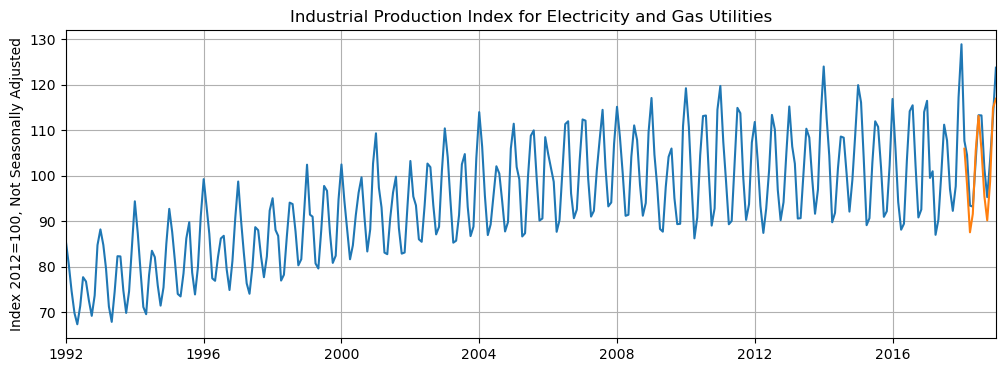

In [38]:
# CODE HERE TO DISPLAY THE END OF THE GRAPH
# DON'T WRITE HERE
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]').astype('datetime64[D]')

plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x,true_predictions)
plt.show()

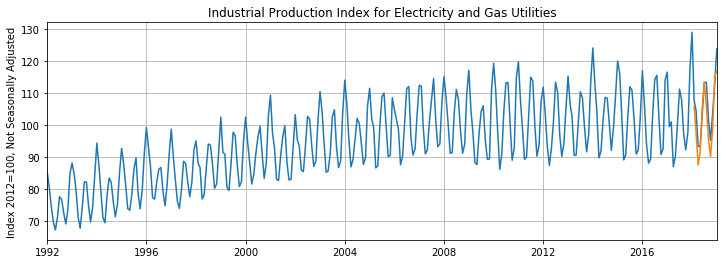

In [12]:
# DON'T WRITE HERE

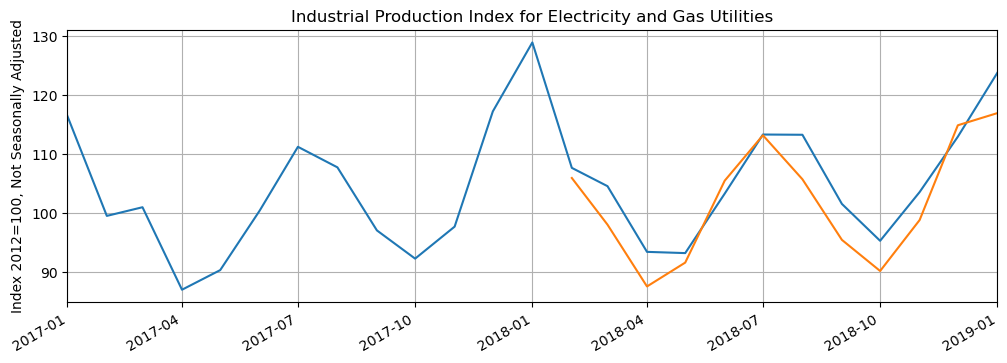

In [39]:
# DON'T WRITE HERE
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(df['IPG2211A2N']['2017-01-01':])
plt.plot(x,true_predictions)
plt.show()

## Great job!